In [112]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [113]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [114]:
RUTA_GUARDADO = "RF.csv"

In [115]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [116]:
def reemplazar_no(df):
    def reemplazo(texto):
        if isinstance(texto, str):
            return texto.replace(" película ", "")
        return texto

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(reemplazo)

    return df

In [117]:
df_train = reemplazar_no(df_train)
df_test = reemplazar_no(df_test)

In [118]:
def normalizar_texto(df, columna):
    reemplazos = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    df[columna] = df[columna].str.lower()
    for clave, valor in reemplazos.items():
        df[columna] = df[columna].str.replace(clave, valor)
    return df[columna]

In [119]:
def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=1, labels=labels)
    precision = precision_score(y, y_pred, pos_label=1, labels=labels)
    recall = recall_score(y, y_pred, pos_label=1, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [120]:
def guardar_resultado_en_csv(prediccion):

    f = lambda e: "positivo" if e == 1 else "negativo"
    f = np.vectorize(f)
    prediccion = f(prediccion)

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [121]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [122]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [123]:
x_test = df_test["review_es"]

In [124]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [126]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [127]:
n_iter = 5

param_distributions = { 
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [1, 5, 10, 20],
    "min_samples_split" : [2, 4, 10, 12, 16, 20],
    "n_estimators": [10, 30, 20, 40, 50, 60, 70, 80, 90, 100],
    "max_depth": range(15, 51) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [128]:
best_rf = randomcv.best_estimator_

In [129]:
best_params_rf = randomcv.best_params_

In [130]:
best_rf = RandomForestClassifier(
            criterion=best_params_rf["criterion"],
            min_samples_leaf=best_params_rf["min_samples_leaf"],
            min_samples_split=best_params_rf["min_samples_split"],
            n_estimators=best_params_rf["n_estimators"],
            max_depth=best_params_rf["max_depth"])

In [131]:
best_rf.fit(x_train_vec, y_train)

y_pred = best_rf.predict(x_test_vec)

F1: 0.839126181936746
Precision: 0.8174310761021472
Recall: 0.8620042872454448
Accuracy: 0.8355333333333334


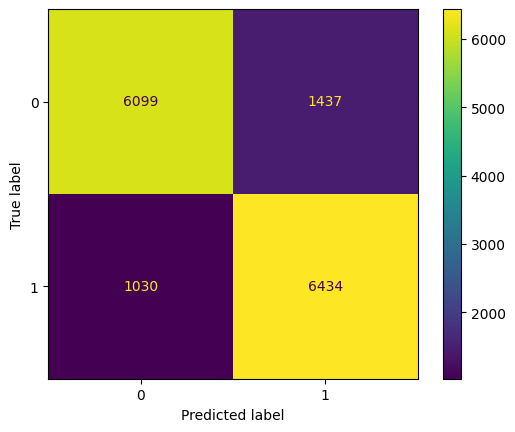

In [132]:
imprimir_resultados(y_test_, y_pred)

In [133]:
y_pred_ = best_rf.predict(vectorizer.transform(x_test))

In [134]:
guardar_resultado_en_csv(y_pred_)